In [229]:
'''    imports    '''
# -*- coding: utf-8 -*-

import numpy as np
import sklearn
import csv
import re

from pandas import read_csv
import pandas as pd

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
import time

from sklearn.metrics import accuracy_score, confusion_matrix


In [242]:
'''    functions    '''
def printEach(list):
    for item in list:
        print(item)
        
def printBestParameter(grid_search):
    # Prints the parameters for grid search
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

def translateNumbers(x):
    # translate indian numbers to arabic numbers
    x = x.replace(u'\u0660','0')
    x = x.replace(u'\u0661','1')
    x = x.replace(u'\u0662','2')
    x = x.replace(u'\u0663','3')
    x = x.replace(u'\u0664','4')
    x = x.replace(u'\u0665','5')
    x = x.replace(u'\u0666','6')
    x = x.replace(u'\u0667','7')
    x = x.replace(u'\u0668','8')
    x = x.replace(u'\u0669','9')
    return x
    
def removePunc(x):    
    # removes punctuation and arabic harakat
    punc = """!$%^&*()-=+.,:'"<>/\?"""
    arabic_semicolon = u"\u061B"
    arabic_comma = u"\u060C"
    arabic_question = u"\u061F"
    arabia_fatha = u"\u064E"
    arabia_2fathas = u"\u064B"
    arabia_damma = u"\u064F"
    arabia_2dammas = u"\u064C"
    arabia_kasra = u"\u0650"
    arabia_2kasras = u"\u064D"
    arabic_sukun = u"\u0652"
    arabic_shadda = u"\u0651"
    punc += arabic_semicolon + arabic_comma + arabic_question + arabia_fatha + arabia_2fathas + arabia_damma + arabia_2dammas + arabia_kasra + arabia_2kasras + arabic_sukun + arabic_shadda
    
    for char in punc:
        x = x.replace(char, "")
        
    return x

def uniformArabic(x):
    # uniform multiple characters to thier origrinal form
    # Alifs -> Alif
    x = x.replace(u'\u0622',u'\u0627')
    x = x.replace(u'\u0623',u'\u0627')
    x = x.replace(u'\u0625',u'\u0627')
    # Taa marbotah -> haa
    x = x.replace(u"\u0629",u"\u0647")
    # Alif_maqsurah + Yaa_Hamzah -> Yaa
    x = x.replace(u'\u0649',u'\u064A')
    x = x.replace(u'\u0626',u'\u064A')
    # Waw_hamzah -> waw
    x = x.replace(u'\u0624',u'\u0648')
    return x

def reduceString(x, string):
    # replaces two same consecutive characters with one
    stringString = string+string
    while stringString in x:
        x = x.replace(stringString, string)
    return x
    
def clean(x):
    # cleans the tweet
    x = translateNumbers(x)
    
    x = re.sub("(https|http)://t.co/([a-zA-Z0-9]){10}"," _LINK_ ",x) # Link
    x = re.sub("[0-9]{10,}"," _NUMBER_ ",x) # Number
    x = re.sub("@.*\s"," _ACCOUNT_ ",x) # Account
    
    x = removePunc(x)
    
    x = uniformArabic(x)
    
    x = reduceString(x, ' ')
    
    # reduce arabic letters
    arabic_letters = [u"\u0627",u"\u0628",u"\u062A",u"\u062B",u"\u062C",u"\u062D",u"\u062E",u"\u062F",u"\u0630",u"\u0631",u"\u0632",u"\u0633",u"\u0634",u"\u0635",u"\u0636",u"\u0637",u"\u0638",u"\u0639",u"\u063A",u"\u0641",u"\u0642",u"\u0643",u"\u0644",u"\u0645",u"\u0646",u"\u0647",u"\u0648",u"\u064A"]
    for letter in arabic_letters:
        x = reduceString(x, letter)
    
    # remove maddah
    x = x.replace(u'\u0640','')
    
    # al + la
    x = reduceString(x, u'\u0627\u0644')
    x = reduceString(x, u'\u0644\u0627')
        
    # english repeated letters
    x = reduceString(x, "a")
    x = reduceString(x, "s")
    x = reduceString(x, "h")
    x = reduceString(x, "o")
    x = reduceString(x, "y")
    
    x = reduceString(x, "_")
    
    # replace the hashtag with cinema
    x = re.sub(u"\u0627\u0644\u0633\u064A\u0646\u0645\u0627_\u0641\u064A_\u0627\u0644\u0633\u0639\u0648\u062F\u064A\u0647"," _cinema_ ",x) # Cinema
    
    return x
    
def cleanAll(X):
    # perform clean on all elements
    clean_x = []
    for x in X:
        clean_x.append(clean(x))
    return clean_x

def lenFeatures(X):
    vectorizer = TfidfVectorizer()
    vect = vectorizer.fit_transform(X)
    print("There are " + str(len(vectorizer.vocabulary_)) + " features")
        
def listFeatures(X):
    # list the features of the tfidf vectorizer
    vectorizer = TfidfVectorizer()
    vect = vectorizer.fit_transform(X)
    terms = vectorizer.get_feature_names()
    
    sums = vect.sum(axis=0)

    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col] ))

    ranking = pd.DataFrame(data, columns=['term','rank'])
    ranking = ranking.sort_values('rank',ascending=False)
    
    print("Highest scored terms:")
    for i in xrange(10):
        print(str(1+i)+": "+ranking['term'].iloc[i])

def doGridSearch(pipeline, parameters):
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
    t0 = time.time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time.time() - t0))

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")

    printBestParameter(grid_search)
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [223]:
'''    main    '''
df = read_csv('corpusCinema.csv', engine='python', encoding="UTF-8")
array =  df.values

X = array[:, 0] #Tweet
Y = array[:, 1] #Sentiment

for n,i in enumerate(Y):
    if i==1:
        Y[n]="Positive"
    elif i==0:
        Y[n]="Neutral"
    elif i==-1:
        Y[n]="Negative"

X = cleanAll(X)
# print(X)
# listFeatures(X)
lenFeatures(X)
    
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=7)

There are 16393 features


In [178]:
model1 = Pipeline([
    ('1', TfidfVectorizer()),
    ('3', SVC(kernel='linear', random_state=7, decision_function_shape='ovo', C=1.3))
])
parameters = {
#     '1__max_df': (0.95, 0.94, 0.96), # 1
#     '1__strip_accents' : ('ascii', 'unicode', None), # None
#     '1__norm' : ('l1', 'l2', None), # l2
#     '1__sublinear_tf' : (True, False), # False
    
#     '3__C': (0.8, 1.0, 1.1, 1.2, 1.3), # 1
#     '3__degree': ( 1,2,3,4), # 3
#     '3__tol': (1e-3,  1e-6, 1e-9), # 1e-3
#     '3__class_weight': (None, 'balanced'), # None
}

doGridSearch(model1, parameters)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished


done in 7.849s
Best score: 0.680
Best parameters set:


In [187]:
model2 = Pipeline([
    ('1', TfidfVectorizer(max_df=0.4)),
    ('3', MultinomialNB(alpha=0.05))
])
parameters = {
#     '1__max_df': (0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.75, 1.0),
    
#     '3__alpha': (1.0e-10, 1.0e-5,0.025, 0.05, 0.075, 0.1,0.15, 0.5, 1),
}

doGridSearch(model2, parameters)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
done in 0.578s
Best score: 0.675
Best parameters set:


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


In [204]:
model3 = Pipeline([
    ('1', TfidfVectorizer()),
    ('3', RandomForestClassifier(random_state=7,n_jobs=-1, n_estimators=150))
])
parameters = {
#     '1__max_df': (0.25, 0.5, 0.75, 1.0), # 1.0
#     '1__use_idf': (True, False), # true
#     '1__norm': ('l1', 'l2'), # l2
    
#     '3__n_estimators': (10, 100, 150, 200), # 10
#     '3__criterion': ('gini', 'entropy'), # gini
#     '3__class_weight': (None, 'balanced'), # None
}

doGridSearch(model3, parameters)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.0s finished


done in 12.577s
Best score: 0.647
Best parameters set:


In [217]:
model4 = Pipeline([
    ('1', TfidfVectorizer()),
    ('3', LogisticRegression(random_state=7, class_weight='balanced', C=1.4,  max_iter=10))
])
parameters = {
#     '1__max_df': (0.5, 0.75, 1.0),
#     '1__strip_accents' : ('ascii', 'unicode', None), # None
#     '1__norm' : ('l1', 'l2', None), # l2
#     '1__sublinear_tf' : (True, False), # False
    
#     '3__class_weight': (None, 'balanced'), # None
#     '3__C': (1.1, 1.2, 1.3, 1.35, 1.4, 1.45, 1.5), # 1
#     '3__solver' : ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'), # liblinear
#     '3__max_iter': (5, 10, 15), # 100
    
}

doGridSearch(model4, parameters)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


done in 0.887s
Best score: 0.675
Best parameters set:


             precision    recall  f1-score   support

   Negative       1.00      0.95      0.98        64
    Nuetral       0.96      0.98      0.97       258
   Positive       0.94      0.94      0.94       144
       Spam       1.00      0.97      0.98        67

avg / total       0.97      0.97      0.97       533



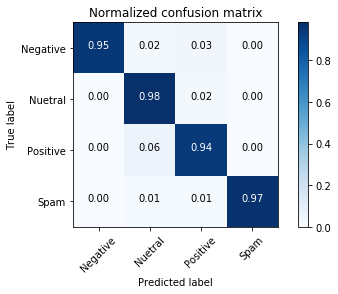

In [243]:
import matplotlib.pyplot as plt

labels = ["Negative","Nuetral","Positive","Spam"]

kfold = model_selection.KFold(n_splits=10, random_state=7)
estimators = [
    ('model1',model1),
    ('model2',model2),
    ('model3',model3),
    ('model4',model4),
]

start = time.time()

ensemble = VotingClassifier(estimators, voting='hard',n_jobs=-1)
ensemble.fit(X, Y)
y_predict = ensemble.predict(X_test)
accuracy_score(y_test, y_predict)
print(classification_report(y_test, y_predict, target_names=labels))

cnf_matrix = confusion_matrix(y_test, y_predict)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True, title='Normalized confusion matrix')
plt.show()